### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Implementierung und Evaluierung der Topic Modelling Modelle: ZeroShotTM -

<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der bereinigten Amazon Daten</ul>
<ul>4. Implementierung des Modells</ul>
    <ul>
     <ul>4.1. Data Preprocessing</ul>
     <ul>4.2. Modellierung</ul>
     <ul>4.3. Visualisierung</ul>
    </ul>
<ul>5. Evaluierung</ul>
    <ul>
     <ul>5.1. Coherence score</ul>
     <ul>5.2. Perplexity</ul>
     <ul>5.3. Similarity</ul>
    </ul>
<ul>6. Literaturverzeichnis</ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Implementierung des Topic Modelling Modells von __ZeroShotTM__ sowie dessen Evaluierung.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter den Kapiteln "5. 5.	ZeroShot Topic Modelling" und "6.	Empirische Evaluierung der Modelle" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [ ]:
# Instalationen
%pip install nltk
%pip install tables
%pip install gitly==1.0.1
%pip install plotly>4.0.0
%pip install umap-learn

# Beschleunigung
# Quelle: https://medium.com/rapids-ai/faster-topic-modeling-with-bertopic-and-rapids-cuml-5c7559aba898
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
%pip install -U contextualized_topic_models

### 2.2. Imports

In [1]:
# Imports und Initalisierungen
import numpy as np
import pandas as pd
import tables

# Natural Language Processing
import nltk
nltk.download('stopwords')

# Datenvisualisierung
import plotly.express as px
import plotly.figure_factory as ff
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')              # Instanziierung des Objekts

# Modelling
import contextualized_topic_models
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file

# Evaluierung
from contextualized_topic_models.evaluation.measures import CoherenceCV, CentroidDistance
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


There are few libs and modules that should be installed in Colab in order to generate static plots from Plotly.
Summary: Install Orca, update plotly and update apt-get

apt-get update
pip install plotly>=4.0.0
wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
chmod +x /usr/local/bin/orca
apt-get install xvfb libgtk2.0-0 libgconf-2-4
Done. Have fun! :)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Laden der bereinigten Amazon Daten

In [4]:
# Review Daten laden
reviews_df = pd.read_hdf('Cleaned_Sport_and_Outdoors.h5')

# Ausgabe
pd.concat([reviews_df], axis=1, sort = False, keys = ["Bereinigter Datensatz: Sport and Outdoors"])

Bereinigter Datensatz: Sport and Outdoors  \
                                                reviewText   
0                  What a spectacular tutu! Very slimming.   
1        What the heck? Is this a tutu for nuns? I know...   
2                        Exactly what we were looking for!   
3        I used this skirt for a Halloween costume and ...   
4        This is thick enough that you can't see throug...   
...                                                    ...   
2264636                     Wife laughs at me but it works   
2264637  2XU makes great compression shorts. A bit more...   
2264638  These are my favorite compression shorts for r...   
2264639  Love the shorts.. amazing comfortable, perfect...   
2264640  I have a briley bolt release paddle installed ...   

                                                                          \
                                               cleanedText  year overall   
0                               spectacular tutu veri slim  2015     5.0   
1        heck tutu nun know cut still also nt sever lay...  2015     1.0   
2                                               exact look  2015     5.0   
3        use skirt halloween costum glue bunch feather ...  2014     5.0   
4        thick enough ca nt see veri long sure check di...  2014     4.0   
...                                                    ...   ...     ...   
2264636                                    wife laugh work  2018     4.0   
2264637  xu make great compress short bit expens well w...  2018     5.0   
2264638  favorit compress short run thinnest materi run...  2018     5.0   
2264639  love short amaz comfort perfect compress perfe...  2018     5.0   
2264640  briley bolt releas paddl instal a xplor sport ...  2017     5.0   

                                                                      \
            brand                                              title   
0        BubuBibi                           Adult Ballet Tutu Yellow   
1        BubuBibi                           Adult Ballet Tutu Yellow   
2        BubuBibi                           Adult Ballet Tutu Yellow   
3        BubuBibi                           Adult Ballet Tutu Yellow   
4        BubuBibi                           Adult Ballet Tutu Yellow   
...           ...                                                ...   
2264636  Columbia                               Columbia Bora booney   
2264637       2XU                  2XU Men's Core Compression Shorts   
2264638       2XU                  2XU Men's Core Compression Shorts   
2264639       2XU                  2XU Men's Core Compression Shorts   
2264640       STS  T&amp;s Shell Catcher Beretta A400 Multitarget...   

                     
               asin  
0        0000032034  
1        0000032034  
2        0000032034  
3        0000032034  
4        0000032034  
...             ...  
2264636  B01HJDZ34I  
2264637  B01HJGAJ9O  
2264638  B01HJGAJ9O  
2264639  B01HJGAJ9O  
2264640  B01HJHHBHG  

[2264641 rows x 7 columns]

#### __Verleinerung des Datensatzes__
ZeroShotTM ist mithilfe der GPU in der Lage größere Datenmengen zu verarbeiten. Jedoch benötigt die Verwendung von UMAP große Kapazitäten der System-RAM. Da aber im Rahmen dieser Masterarbeit durch die begrenzten RAM der Datensatz verkeleinert werden musste, wird für alle Topic Modelling Modelle der gleiche Datensatz verwendet. Dadurch können die Ergebnisse der Evaluierung besser verglichen werden.

In [5]:
# Verleinerung des Datensatzes Aufgrund der Performence
reviews_df = reviews_df.iloc[ :100000,]

# Liste erzeugen mit den Reviews
docs_list = reviews_df.reviewText.values.tolist()

## 4. Implementierung des Modells

### 4.1. Data Preprocessing

####__Einfache Bereinigung__

Während bei den meisten Topic Modelling Modellen eine Bereinigung der Daten erforderlich ist, um bessere Ergebnisse zu erziehlen, ist es bei kontextualisierten Modellen von Vorteil dies nicht zu tun. Diese Algorithmen arbeiten kontextbezogen und nutzen diesen daher zur Erstellung der Topics. Aus diesem Grund wird im Folgenden lediglich ein verkürtztes Preprocessing durchgeführt, welches englische Stopwords und die Satzzeichen entfernt. Des Weiteren wird ein Vokabular mit den wichtigsten 2000 Token erzeugt, welche dazu genutzt werden die Themen zu repräsentieren (Bianchi, 2021).

In [6]:
# Durchführen des einfaches Data Preprocessing (Satzzeichen und Stopwords)
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
cleaned_list = WhiteSpacePreprocessing(docs_list, stopwords_language='english')

# Rückgabe der Werte aus der Funktion
unpreprocessed_documents = cleaned_list.preprocess()[0]   # Rückgabe der unverarbeiteten Daten
preprocessed_documents = cleaned_list.preprocess()[1]     # Rückgabe der vorverarbeiteten daten
vocabulary = cleaned_list.preprocess()[2]                 # Rückgabe der Wörter
token = cleaned_list.preprocess()[3]                      # Rückgabe der 2000 häufigsten Token

####__Vektorisierung__

Nach der Bereinigung wird ein Trainingsset aus vektorisierten Daten erstellt, welches sich aus einem Korpus für den Kontext und aus einem Korpus für die Bag-of-Words Darstellung zusammensetzt. Üblicherweise verwendet ZeroShotTM das Embedding „paraphrase-multilingual-mpnet-base-v2“ der Sentence Transformers von SBERT (Bianchi, 2021). Da jedoch im Rahmen der Masterarbeit keine multilingualen Texte untersucht werden, wird für eine bessere Vergleichbarkeit das schon bei BERTopic verwendete Modell „all-MiniLM-L6-v2“ implementiert.

In [9]:
# Instanzialisierung des kontextualisierten Modell
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
embedding_model = TopicModelDataPreparation("all-MiniLM-L6-v2")

# Erstellung des Training sets
embeddings = embedding_model.fit(text_for_contextual=unpreprocessed_documents, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

### 4.2. Modellierung
#### __Initialisierung des Modells__

Die vorverarbeiteten Embeddings enthalten die 2.000 Wörter, welche am häufigsten Auftreten. Auf diese Weise sollen wenig aussagekräftige Wörter entfernt werden, um den Trainingsprozess zu optimieren. Zur Initialisierung des Objekts wird die Länge des Vokabulars und und die Länge der Embedings aus „X_contextual“ übergeben. Über den Paramter „n_components“ kann festgelegt werden, wie viele Topics aus dem Modell generiert werden sollen. Ist dieser Parameter nicht gesetzt, so werden stets zehn Topics identifiziert (Bianchi, Contextualized Topic Modeling with Python (EACL2021), 2021).

In [12]:
# Initialisierung des Topic Modelling Modells
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
# , n_components=50
zeroshot_model = ZeroShotTM(bow_size=len(embedding_model.vocab),
                            contextual_size=embeddings[1]["X_contextual"].shape[0])

#### __Anwendung auf den Datensatz__

In [14]:
# Anwendung des Modells auf den Datensatz
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
zeroshot_model.fit(embeddings)

Epoch: [100/100]	 Seen Samples: [9990400/9992900]	Train Loss: 447.6443400703738	Time: 0:00:24.844499: : 100it [42:36, 25.56s/it]
100%|██████████| 1562/1562 [00:24<00:00, 63.67it/s]


### 4.3. Visualisierung
Mithilfe unterschiedlicher Funktionen lassen sich die wichtigsten Informationen aus dem Modell extrahieren.
Um ein Verständnis für die Häufigkeit der Schlüsselwörter zu bekommen bietet ZeroShotTM die Möglichkeit über die Funktion "get_wordcloud" eine Wordcoud für ein bestimmtes Topic zu erstellen  (Bianchi, Contextualized Topic Modeling with Python (EACL2021), 2021).



In [16]:
# Anzahl der Identifizierten Topics
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
number_of_topics = len(zeroshot_model.get_topics())
embeddings_len = len(embeddings)

# Ausgabe
print(f"Mithilfe von ZeroShotTM wurden {number_of_topics} Topics in den Review Daten identifiziert.")
print(f"Die Daten wurden von 100.000 auf {embeddings_len} Reviews gekürzt.")

Mithilfe von ZeroShotTM wurden 10 Topics in den Review Daten identifiziert.
Die Daten wurden von 100.000 auf 99929 Reviews gekürzt.


In [17]:
# Ausgabe der ersten 10 Themen
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models
topics = zeroshot_model.get_topic_lists(10)[:10]

# Speichern der Ergebnisse in einer Liste
topic_list = []
for i in range(len(topics)):
    element = [i, topics[i]]
    topic_list.append(element)

# Übertragen der Ergebisse in einen DataFrame
topics_df = pd.DataFrame(topic_list, columns=["Topic_number","Words"])

# Ausgabe
topics_df

,Topic_number,Words
0,0,"[camp, cooler, backpacking, food, trip, pack, ..."
1,1,"[considered, coat, meaning, micro, drawback, a..."
2,2,"[socks, pants, gloves, pair, her, she, balls, ..."
3,3,"[was, up, so, on, to, have, in, water, it, that]"
4,4,"[targets, rings, rifle, sights, 22, tires, ins..."
5,5,"[delivery, delivered, thank, shipped, describe..."
6,6,"[extreme, scale, internal, admit, entirely, gr..."
7,7,"[is, the, this, with, it, knife, for, be, but,..."
8,8,"[whistle, disc, bass, chalk, trout, flies, lur..."
9,9,"[considered, complained, meaning, drawback, sa..."


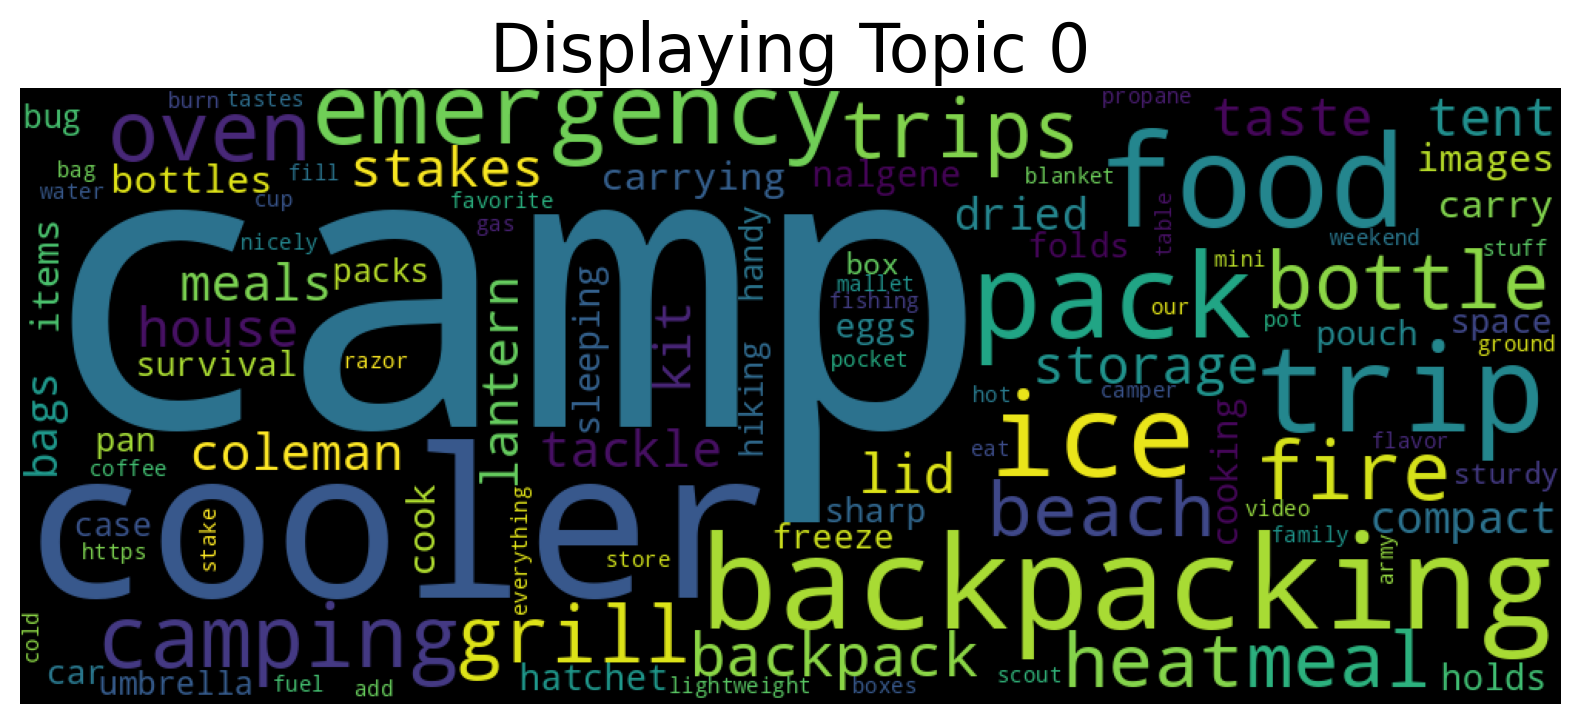

In [18]:
zeroshot_model.get_wordcloud(topic_id=0, n_words=100)

## 5. Evaluierung

Um die Topic Modelling Modelle bewerten zu können, ist es wichtig geeignete Metriken und Validierungsmöglichkeiten heranzuziehen. Auf diese Weise lässt sich herausfinden wie gut die Themenklassifizierung funktioniert hat (Pascual, Topic Modeling: An Introduction, 2019). Im Allgemeinen lassen sich zwei verschiedenen Herangehensweisen unterscheiden: die Intrinsische und die extrinsische Clustervalidität.Im Rahmen dieser Masterarbeit wird auf intrinsische Clustervaliditätsmetriken zurückgegriffen, welche strukturelle Eigenschaften der Cluster berücksichtigt und semantische Merkmale vergleichen (Rüdiger, Antons, Joshi, & Salge, 2022).

Befor mit der Anwendung der Evaluierungsmetriken begonnen werden kann, müssen die notwendigen Parameter dafür erzeugt werden.

In [19]:
# Splitten der Reviewtexte in Token
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models/blob/master/tests/test_measures.py
token_list = [doc.split() for doc in docs_list]

In [20]:
# Extraktion der Vektoren für die Reviewtexte
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models/blob/master/tests/test_measures.py
x_contextual = []
for i in range(len(embeddings)):
  x_contextual.append(embeddings[i]["X_contextual"])

# Transformation eines jeden Pytorch Tensors in eine Liste (Wegen der Performance außerhalb des Loops)
x_contextual = [vector.tolist() for vector in x_contextual]

# Speichern der Informationen in einen DataFrame
documents_df = pd.DataFrame(list(zip(unpreprocessed_documents,x_contextual)), columns = ['Document','Vector'])

In [21]:
# Extraktion der Topics aus den Embeddings (10 Wahrscheinlichkeiten für 10 Topics pro Review)
# Quelle: https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576
# Extraktion der Wahrscheinlichkeiten
topics_predictions = zeroshot_model.get_thetas(embeddings)

# Erstellen 2 leerer Listen
topic_number_list = []
topic_words_list = []

# Extraktion des Topics mit der höchsten Wahrscheinlichkeit
for i in range(topics_predictions.shape[0]):
  topic_number = np.argmax(topics_predictions[i])

  # Extraktion der repräsentativsten Wörter für das Topic
  topic_words = zeroshot_model.get_topic_lists()[topic_number]

  # Hinzufügen der Werte zu den jeweiligen Listen
  topic_number_list.append(topic_number)
  topic_words_list.append(topic_words)

# Erstellen eines DataFrames
documents_df["Topic_number"] = topic_number_list
documents_df["Words"] = topic_words_list

100%|██████████| 1562/1562 [00:24<00:00, 64.99it/s]


### 5.1.1. Coherence Score
Die Kohärenz bezieht sich auf die semitische Verbundenheit der Wörtern, wodurch Sinnbeziehungen in einem Text entstehen, was auf den Leser semantisch konsistent und logisch wirkt (Rüdiger, Antons, Joshi, & Salge, 2022). Verallgemeinert gesagt ist eine Aussage kohärent, wenn sich die Inhalte gegenseitig stützen (Kapadia, 2019).



#### __Durchschnittlicher Coherence Score des Modells__

Wie bereits in der theoretischen Ausarbeitung dieser Masterarbeit beschrieben, stellt der Kohärenzscore eines Modells die aggregierten Themenkohärenzen der einzelnen Topics dar und gibt Aufschluss darüber wie gut das Modell die Sinnbeziehungen der gesammten Reviews erkannt und geclustert hat. Das Ergebnis kann zwischen 0 und 1 liegen und je mehr dieses sich der 1 annähert, desto höher ist die semantische Verbundeheit der Wörter und Themen (Pedro, 2022).

In [22]:
# Initialisierung des Kohärenzmodells
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models/blob/master/contextualized_topic_models/evaluation/measures.py
coherence_model = CoherenceCV(texts=token_list, topics=topics)

# Ermittlung des Kohärenzscores
coherence = coherence_model.score()

# Ausgabe
print('Coherence Score von ZeroShotTM beträgt: ', coherence)

Coherence Score von ZeroShotTM beträgt:  0.429119613355898


#### __Themenkohärenz__

Mithilfe von Themenkohärenzmaße lässt sich die Ähnlichkeit der Wörter in Bezug auf ein bestimmtes Thema messen (Kapadia, 2019). Auf diese Weise können die Topics identifiziert werden, welche semantisch schlüssig interpretiert werden können.
Hier gilt ebenfalls: Je höher der Score, desto höher die Ähnlichkeit der Wörter im Cluster.

In [23]:
# Kohärenz Score pro Topic ermitteln
# Quelle: https://github.com/MilaNLProc/contextualized-topic-models/blob/master/contextualized_topic_models/evaluation/measures.py
coherence_per_topic = coherence_model.score(per_topic=True)

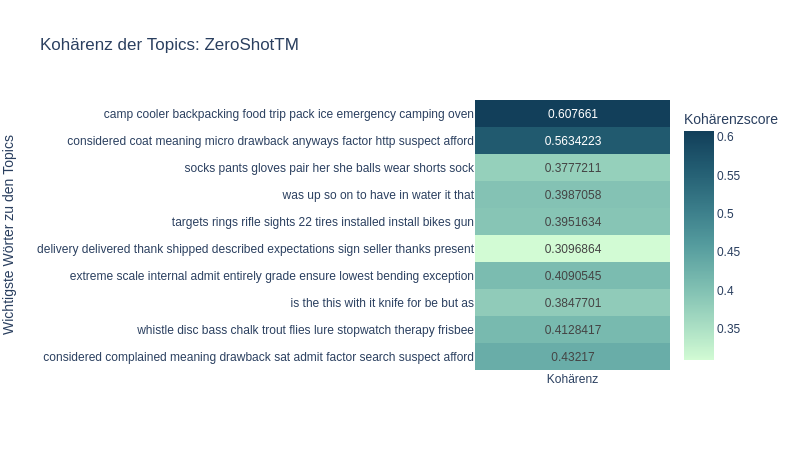

In [24]:
# Graphische Darstellung
# Speichern der Themenkohörenz und der Topics in einem DataFrame
score_per_topic_df = pd.DataFrame( data=zip(topics_df["Words"], coherence_per_topic), columns=['Topic', 'Kohärenz'])

# Umwandeln der Topics in einen string
for index, row in score_per_topic_df.iterrows():
  score_per_topic_df.at[index,"Topic"] = " ".join(row.Topic)

# Setzten des der Liste von Wörter (der Topics) als Index
score_per_topic_df = score_per_topic_df.set_index('Topic')

# Darstellung der Themenkohärenz in einer Heatmap
fig_topic_coherence = px.imshow(score_per_topic_df, text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Darkmint, title = "Kohärenz der Topics: ZeroShotTM",
                                labels = dict(color = "Kohärenzscore", y = "Wichtigste Wörter zu den Topics"), height = 600, width = 800)


# Speichern in einem HTML File
fig_topic_coherence.write_html("ZeroShotTM_Coherence.html")

# Ausgabe
gitly.show(fig_topic_coherence)

### 5.1.2. Perplexity

Die Perplexity gibt Aufschluss darüber wie gut ein Modell neue Daten verallgemeinern und vorhersagen kann, indem es den Abstand der Themenverteilung des Modells und der gleichmäßigen Wortverteilung des erstellten Wörterbuches misst (Rüdiger, Antons, Joshi, & Salge, 2022). Ein Modell hat ein „gutes Verständnis“ über eine Sprache, wenn es ein semantisch korrektes und häufig auftretendes Wort eine hohe Wahrscheinlichkeit zuweist und einem Seltenem eine niedrige Wahrscheinlichkeit. Aufgrund der umgekehrten Wahrscheinlichkeit, ist eine geringe Perplexity als eine hohe Performence des Modells zu interpretieren (Campagnola, 2020).

In [25]:
# Erstellen verkürzter Vektoren zur Errechnung der Perplexity
vector_list = []
for i in range(len(embeddings)):
  vector_list.append(embeddings[i]["X_contextual"][:10])

# Transformation eines jeden Pytorch Tensors in eine Liste (Wegen der Performance außerhalb des Loops)
vector_list = [vector.tolist() for vector in vector_list]

In [26]:
# Erechnung der logaritmische Perplexity
# Quelle: https://huggingface.co/docs/transformers/perplexity
log_perplexity = -1 * np.mean(np.log(np.sum(vector_list)))

perplexity = np.exp(log_perplexity)

# Ausgabe
print('Die Perplexity für ZeroShotTM beträgt: ', perplexity)

Die Perplexity für ZeroShotTM beträgt:  0.00034933751166723887


### 5.1.3. Similarity

Die „Cosine Similarity“ gibt ein Maß für die Ähnlichkeit zweier Vektoren wieder, welche sich in einem mehrdimensionalen Raum befinden. Der Score basiert auf dem Kosinus der Winkelmessung und bezieht sich auf die Orientierung der Vektoren im Raum anstatt auf deren Länge(Sitikhu, Pahi, Thapa, & Shakya, 2019, S. 2).
Das Ergebnis der Kosinusähnlichkeit kann zwischen -1 und 1 liegen. Wenn ein Winkel zwischen zwei Vektoren klein ist, tendiert der Kosinus des Winkels gegen eins, was sich als ein hohes Maß an Ähnlichkeit interpretieren lässt. Je größer der Winkel wird, desto unähnlicher sind sich die Dokumente. Bei 90° und einem Kosinus Wert um null spricht man von orthogonalen Vektoren. Nimmt Kosinus den Wert -1 an, so nähert sich deren Winkel 180° und die Reviews bzw. Wörter sind mit einem gegenteiligen Inhalt zu interpretieren (Supe, 2023).

Befor die Similarity Scores berechnet werden können, müssen die Daten noch in das passende Format transformiert werden:

In [27]:
# Erstellen der Gruppierung der Vektoren pro Topic
# Erstellen einer leeren Liste für die Vectoren
vector_dict = {}

# Extrahieren der Topics
topics_unique = np.sort(documents_df.Topic_number.unique())

# Befüllen des Dictionaries mit den Vectoren pro Topic
for topic in topics_unique:
  vector_dict[str(topic)] = documents_df.loc[documents_df["Topic_number"] == topic].Vector.tolist()

#### __Similarity zwischen den Reviews eines Topics__

Um zu identifizieren, ob sich die Reviews innerhalb eines Topics ähndeln und somit auf einen gleichen Inhalt geschlussfolgert werden kann, wird im folgeden der Similarity Score zwischen den Reviews innerhalt eines Topics berechnent.
Je weiter die Werte gegen 1 tendieren, desto ähnlicher sind die Reviews, welche diesem Topic zugeordnet wurden (Supe, 2023).

In [28]:
# Similarity Scores pro Topic
# Quelle: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# Erstellen eines DataFrames
similarity_df = pd.DataFrame(topics_unique, columns=["Topic_number"])
similarity_df["Similarity"] = ""

# Schleife zur Errechnung des Similarity Scores pro Topic
for key in vector_dict:
  similarity = cosine_similarity(vector_dict[key]).mean()
  similarity_df.loc[similarity_df["Topic_number"] == int(key), "Similarity"] = similarity

# Konvertierung der Spalten in das richtige Datenformat
similarity_df["Topic_number"] = similarity_df["Topic_number"].astype(str)
similarity_df["Similarity"] = similarity_df["Similarity"].astype(float)

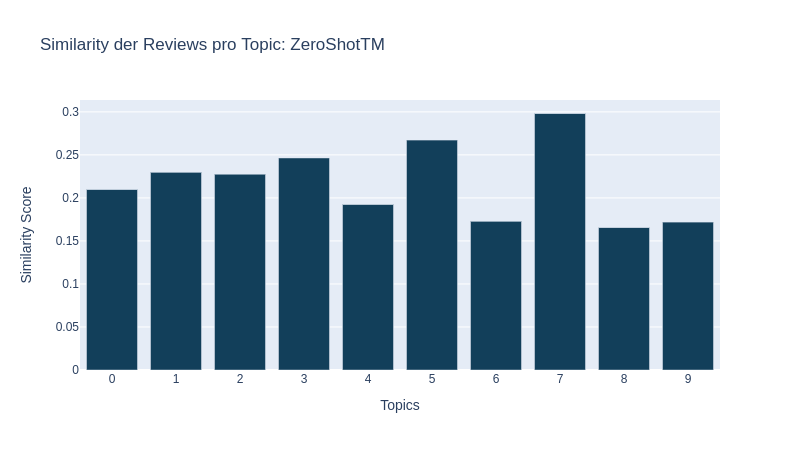

In [29]:
# Graphische Darstellung
similarity_fig = px.bar(similarity_df, x="Topic_number", y="Similarity", title="Similarity der Reviews pro Topic: ZeroShotTM",
                        color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update Layout
similarity_fig.update_xaxes(title_text= "Topics")
similarity_fig.update_yaxes(title_text= "Similarity Score")

# Speichern in ein HTML File
similarity_fig.write_html("ZeroShotTM_Similarity_per_Topic.html")

# Ausgabe
gitly.show(similarity_fig)

#### __Topic Similarity Matrix__

Mithilfe der Topic Similarity Matrix lassen sich ähnliche Topics identifizieren, welche sich mit ähnlichen Inhalten befassen. Die Abbildung wurde in Anlehnung an die "Topic Similarity Matrix" von BERTopic erstellt. Für die Ermittlung des Cosine Similarity Scores werden die Vektoren der Topics miteinander verglichen (Grootendorst, Heatmap, 2023). Die Diagonale bildet den Similarity Score des Topics ab, welches bereits im Schritt zuvor berechnet wurde.

In [30]:
# Erstellen der Topic Similarity Matrix
# Erstellen einer leeren Matrix
matrix_for_heat_map = np.zeros((10,10))

# Transformation des NumPy arrays zu einer Liste für schnelleren Loop
topics_unique = list(topics_unique)

# Loop über die Spalten und Zeilen zur Befüllung der Matrix
for col in range(len(topics_unique)):
  for row in range(len(topics_unique)):
    # Errechnung des durchschnittlichen Simiarity Scores
    similarity_between_topics = cosine_similarity(vector_dict[str(topics_unique[col])],
                                                  vector_dict[str(topics_unique[row])]).mean()
    # Hinzufügen des Scores in die Matrix
    matrix_for_heat_map[row,col] = similarity_between_topics

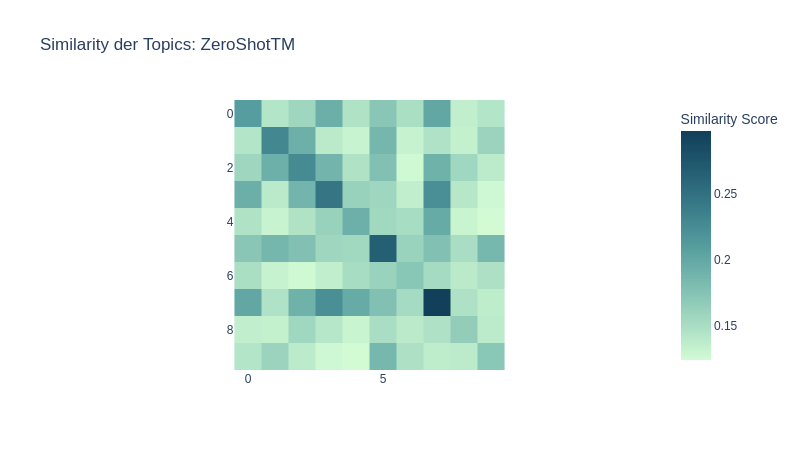

In [31]:
# Graphische Darstellung
similarity_topics_fig = px.imshow(matrix_for_heat_map, title="Similarity der Topics: ZeroShotTM",
                                  labels=dict(color="Similarity Score"),
                                  width= 600,
                                  color_continuous_scale=px.colors.sequential.Darkmint)

# Speichern in ein HTML File
similarity_topics_fig.write_html("ZeroShotTM_Similarity_between_Topic.html")

# Ausgabe
gitly.show(similarity_topics_fig)

#### __Intertopic Distanz der Topics__

Mithilfe der Intertopic Distanz Map lässt sich die Entfernung zwischen den Themen messen. Je ähnlicher sich die Themen sind, desto näher liegen diese beieinander und können sich sogar überlappen, falls diese teilweise identische Inhalte aufweisen. Je weiter die Blasen in dem Diagramm voneinander entfernt sind, desto mehr unterscheiden sich die Themen voneinander. Die Größe der Kreise repräsentieren die Anzahl der im Topic enthaltenen Reviews (Amy, 2022). Während andere Modelle, wie BERTooic oder LDA eine derartige Darstellung standardmäßig implementiert haben, wurde für LSA eine vergleichbare Darstellung manuell erstellt. Die Logik orientiert sich an den Berechnungen von BERTopic (Grootendorst, Topics, 2023).

In [32]:
# Erstellen der Intertopic Distanz Map (Inspiriert von BERTopic)
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/topics.html#bertopic.plotting._topics.visualize_topics
# Speichern der Vektoren in einer Liste
embeddings = documents_df.Vector.values.tolist()

# Auf eine Zweidimensionale Ebene bringen
embeddings_2D = UMAP(n_neighbors=2, n_components=2, metric='cosine', random_state=42, verbose=True).fit_transform(embeddings)

# Hinzufügen der Spalten in den DataFrame "documents_df"
documents_df = documents_df.assign(x=embeddings_2D[:, 0], y=embeddings_2D[:, 1])

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=2, random_state=42, verbose=True)
Fri Aug 11 10:14:41 2023 Construct fuzzy simplicial set
Fri Aug 11 10:14:41 2023 Finding Nearest Neighbors
Fri Aug 11 10:14:41 2023 Building RP forest with 21 trees
Fri Aug 11 10:14:49 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Fri Aug 11 10:15:03 2023 Finished Nearest Neighbor Search
Fri Aug 11 10:15:05 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Aug 11 10:20:40 2023 Finished embedding


In [33]:
# Gruppieren nach 'Topic_number' und Aggregation der x und y Vektoren
frequency_df = documents_df.groupby('Topic_number').agg(count=('Topic_number', 'count'),
                                                        x_mean=('x', 'mean'),
                                                        y_mean=('y', 'mean')).reset_index()

# Konvertieren der Topic_number in das richtige Format
frequency_df["Topic_number"] = frequency_df["Topic_number"].astype(str)
topics_df["Topic_number"] = topics_df["Topic_number"].astype(str)

# Ergänzen um die Namen der Topics und deren Wahrscheinlichkeiten
frequency_df = frequency_df.merge(topics_df, on="Topic_number", how="left")

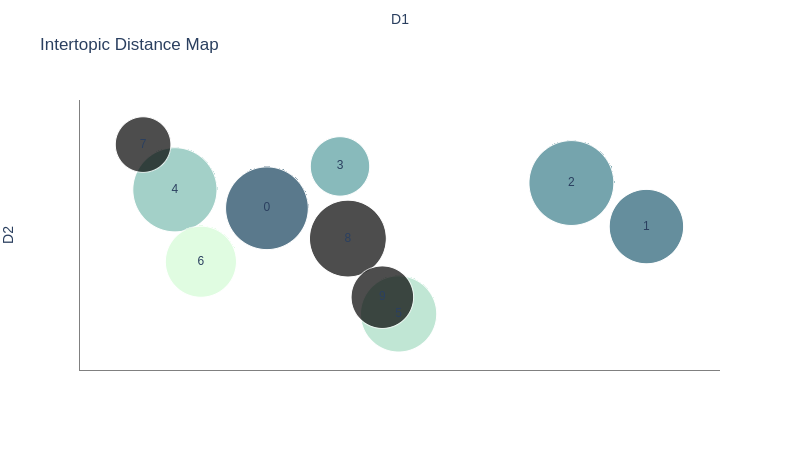

In [34]:
# Graphische Darstellung
intertopic_distanz_fig = px.scatter(frequency_df, x="x_mean", y="y_mean",
                                    size = "count",
                                    hover_name = "Words",
                                    text="Topic_number",
                                    size_max = 60,
                                    width= 600,
                                    height= 600,
                                    title = "Intertopic Distance Map")

# Layout updaten
intertopic_distanz_fig.update_traces(marker=dict(color=px.colors.sequential.Darkmint_r))
intertopic_distanz_fig.update_layout(plot_bgcolor="white",
                                     paper_bgcolor="white",

                                     showlegend=False)

# x- und y-Achse Updaten
intertopic_distanz_fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D1")
intertopic_distanz_fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D2")

# Speichern in ein HTML File
intertopic_distanz_fig.write_html("ZeroShotTM_Intertopic_Distance_Map.html")

# Ausgabe
gitly.show(intertopic_distanz_fig)

#### __Hierarchisches Clustering__

Mithilfe dieser Visualisierungsform, lassen sich die  hierarchische Struktur der Topics visualisieren. Auf diese Weise lassen sich die Inhaltlichen Beziehungen von Themen identifizieren, welche miteinander Verbunden sind. Des weiteren werden Themengruppen erseichtlich sowie eine Strukturierung in Unter- und Überthemen. In Anlehnung an BERTopic wurde hierfür eine Ward-Linkage-Funktion von Plotly erstellt, welche die hierarchische Clusterbildung auf Basis der bereits berechneten Kosinus-Similarity-Distanzmatrix der Topics abbildet (Grootendorst, Hierarchy, 2023).

In [35]:
# Umwandeln der Topic Embeddings in ein 2 dimensionales Array
embeddings_array = frequency_df[['x_mean','y_mean']].to_numpy()

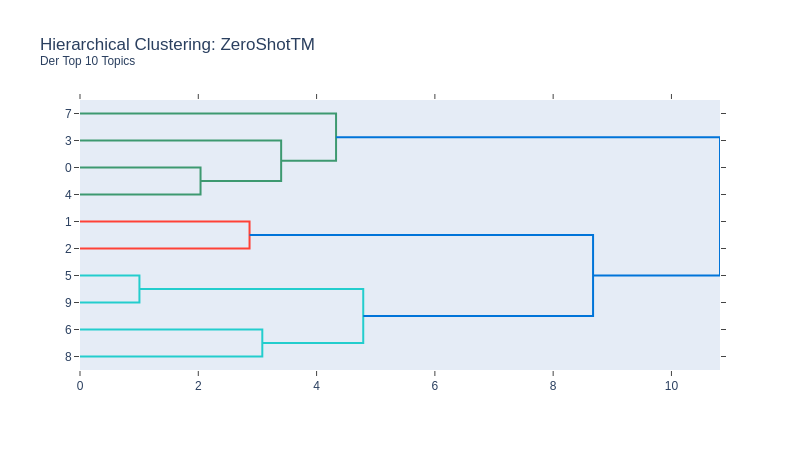

In [36]:
# Graphische Darstellung
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html#bertopic.plotting._hierarchy.visualize_hierarchy
# Quelle: https://plotly.com/python/dendrogram/
hierarchical_topics_fig = ff.create_dendrogram(embeddings_array,
                                               orientation="left")

# Update Laout
hierarchical_topics_fig.update_layout(title= "Hierarchical Clustering: ZeroShotTM <br><sup>Der Top 10 Topics</sup>")

# Speichern in einem HTML File
hierarchical_topics_fig.write_html("ZeroShotTMc_Hierachical_Clustering.html")

# Ausgabe
gitly.show(hierarchical_topics_fig)

## 6. Literaturverzeichnis

Amy. (21. 10 2022). Topic Modeling with Deep Learning Using Python BERTopic. Abgerufen am 05. 08 2023 von medium.com: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

Bianchi, F. (11. 02 2021). Contextualized Topic Modeling with Python (EACL2021). Abgerufen am 30. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576

Bianchi, F., Terragni, S., Hovy, D., Nozza, D., & Fersini, E. (16. 05 2020). Cross-lingual Contextualized Topic Models with Zero-shot Learning. Abgerufen am 30. 07 2023 von Bocconi University: https://arxiv.org/pdf/2004.07737v1.pdf

Campagnola, C. (18. 05 2020). Perplexity in Language Models. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

Grootendorst, M. (2023). Heatmap. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html#bertopic.plotting._heatmap.visualize_heatmap

Grootendorst, M. (2023). Hierarchy. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html

Grootendorst, M. (2023). Topics. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/topics.html

Kapadia, S. (19. 08 2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). Abgerufen am 21. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Pascual, F. (26. 09 2019). Topic Modeling: An Introduction. Abgerufen am 13. 12 2022 von monkeylearn.com: https://monkeylearn.com/blog/introduction-to-topic-modeling/

Pedro, J. (10. 01 2022). Understanding Topic Coherence Measures. Abgerufen am 23. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Rüdiger, M., Antons, D., Joshi, A. M., & Salge, T.-O. (28. 04 2022). Topic modeling revisited: New evidence on algorithm performance and quality metrics. Abgerufen am 13. 06 2023 von journals.plos.org: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0266325

Sitikhu, P., Pahi, K., Thapa, P., & Shakya, S. (31. 10 2019). A Comparison of Semantic Similarity Methods for Maximum Human Interpretability. Abgerufen am 05. 08 2023 von Department of Electronics and Computer Engineering, Tribhuwan University: https://arxiv.org/pdf/1910.09129.pdf

Supe, K. (07. 06 2023). Understanding Cosine Similarity in Python with Scikit-Learn. Abgerufen am 05. 08 2023 von memgraph.com/: https://memgraph.com/blog/cosine-similarity-python-scikit-learn


